In [218]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]))

from Agents import QLearningAgent, BayesianQAgent, PSRLAgent, MomentMatchingAgent, UbeNoUnrollAgent
from Environments import DeepSea, WideNarrow, PriorMDP
from utils import solve_tabular_continuing_PI, run_experiment, run_oracle_experiment, load_agent

from tqdm import tqdm_notebook as tqdm

# For saving figures and agents
if not os.path.exists('results'): os.mkdir('results')
if not os.path.exists('results/figures'): os.mkdir('results/figures')
if not os.path.exists('results/agent_logs'): os.mkdir('results/agent_logs')

fig_loc = 'results/figures/'

plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=50)

# Environment constants

In [268]:
# PriorMDP constants
num_time_steps = 5000
save_every = num_time_steps // 100
plot_time = 5000

Ns = 4
Na = 2

env_params = {'Ns'         : Ns,
              'Na'         : Na,
              'kappa'      : 1.0,
              'mu0'        : 0.0,
              'lamda'      : 1.0,
              'alpha'      : 4.0,
              'beta'       : 4.0,
              'seed'       : 1}

# Define environment
environment = PriorMDP(env_params)

# Number of PI steps and maximum buffer length (PSRL, UBE and MM only)
max_iter = 6 * Ns
max_buffer_length = Ns + 1

# Bayesian Q-Learning

In [269]:
# Agent parameters
agent_params = {'gamma'               : 0.9,
                'mu0'                 : 0.0,
                'lamda'               : 4.0,
                'alpha'               : 3.0,
                'beta'                : 3.0,
                'num_mixture_samples' : 1000,
                'sa_list'             : environment.sa_list()}

In [270]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent =  BayesianQAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=1,
#                    save_every=save_every)

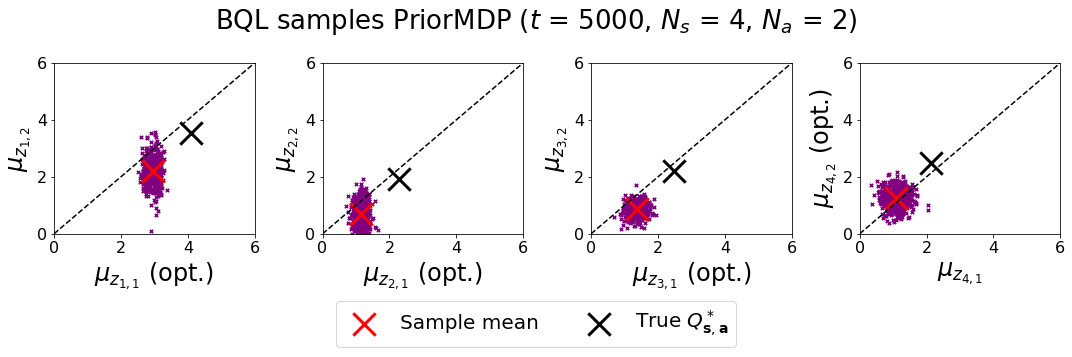

In [271]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, BayesianQAgent(agent_params), seed=0)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
agent.Qpost = agent.Qpost_log[T]
for s in range(Ns):
    samples.append([])
    for i in range(500):

        environment.s = s
        samples[-1].append(agent.take_action(s, 0, reduce_max=False)[0])
        
samples = np.array(samples).swapaxes(0, 1)

optimal_actions = np.argmax(Q, axis=-1)

fig = plt.figure(figsize=(15, 5))
for s in range(Ns):
    
    plt.subplot(1, Ns, s + 1)
    
    plt.scatter(samples[:, s, 0], samples[:, s, 1], color='purple', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, s, 0].mean(), 
                         samples[:, s, 1].mean(), 
                         color='red', 
                         marker='x', 
                         s=500,
                         linewidth=3)
    
    leg[1] = plt.scatter(Q[s, 0], Q[s, 1], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 6, 2), np.linspace(0, 6, 2), '--', color='black')
    
    plt.xlim([0, 6])
    plt.ylim([0, 6])
    
    xlabel = '$\mu_{z_{' + str(s + 1) + ', 1}}$'
    ylabel = '$\mu_{z_{' + str(s + 1) + ', 2}}$'
    
    if optimal_actions[s] == 0:
        xlabel += ' (opt.)'
    else:
        ylabel += ' (opt.)'
        
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    

plt.tight_layout()
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'BQL samples PriorMDP ($t$ = {}, $N_s$ = {}, $N_a$ = {})'
plt.suptitle(title.format(plot_time, Ns, Na), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'bql-{}-{}-{}-{}-scatter-priormdp-{}-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na, plot_time)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# PSRL

In [272]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'max_iter'         : max_iter,
                'sa_list'          : environment.sa_list()}

In [273]:
# for seed in tqdm(range(10)):
    
#     # Define agent
#     agent = PSRLAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

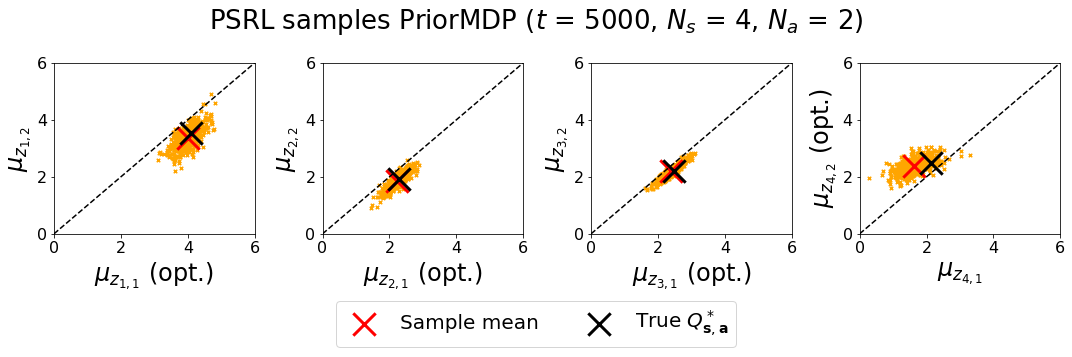

In [274]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, PSRLAgent(agent_params), seed=0)
samples = []

T = plot_time // save_every
agent.Ppost = agent.Ppost_log[T]
agent.Rpost = agent.Rpost_log[T]
for i in range(500):

    environment.s = s
    P, R = agent.sample_posterior()
    Q_ = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)[1]

    samples.append(Q_)
            
samples = np.array(samples)

optimal_actions = np.argmax(Q, axis=-1)

fig = plt.figure(figsize=(15, 5))
for s in range(Ns):
    
    plt.subplot(1, Ns, s + 1)
    
    plt.scatter(samples[:, s, 0], samples[:, s, 1], color='orange', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, s, 0].mean(), 
                         samples[:, s, 1].mean(), 
                         color='red', 
                         marker='x', 
                         s=500,
                         linewidth=3)
    
    leg[1] = plt.scatter(Q[s, 0], Q[s, 1], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 6, 2), np.linspace(0, 6, 2), '--', color='black')
    
    plt.xlim([0, 6])
    plt.ylim([0, 6])
    
    xlabel = '$\mu_{z_{' + str(s + 1) + ', 1}}$'
    ylabel = '$\mu_{z_{' + str(s + 1) + ', 2}}$'
    
    if optimal_actions[s] == 0:
        xlabel += ' (opt.)'
    else:
        ylabel += ' (opt.)'
        
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    
    
plt.tight_layout()
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'PSRL samples PriorMDP ($t$ = {}, $N_s$ = {}, $N_a$ = {})'
plt.suptitle(title.format(plot_time, Ns, Na), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta = agent.mu0, agent.lamda, agent.alpha, agent.beta
save_name = 'psrl-{}-{}-{}-{}-scatter-priormdp-{}-{}-{}'.format(mu0, lamda, alpha, beta, Ns, Na, plot_time)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [275]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [276]:
# for seed in tqdm(range(10)):
    
#     # Define agent
#     agent = UbeNoUnrollAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

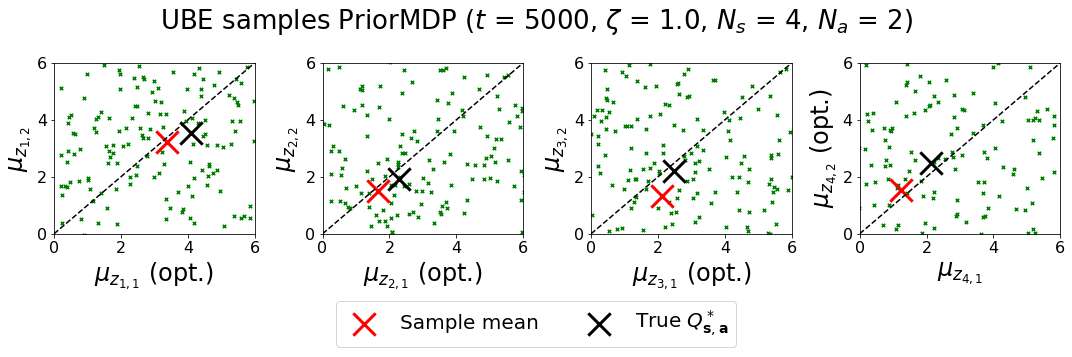

In [277]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
Qmu = agent.Qmu_log[T]
Qvar = agent.Qvar_log[T]
for s in range(Ns):
    samples.append([])
    for i in range(500):
        
        environment.s = s
        samples[-1].append(np.random.normal(Qmu[s, :], agent.zeta * Qvar[s, :]**0.5))
            
samples = np.array(samples).swapaxes(0, 1)

fig = plt.figure(figsize=(15, 5))
for s in range(Ns):
    
    plt.subplot(1, Ns, s + 1)
    
    plt.scatter(samples[:, s, 0], samples[:, s, 1], color='green', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, s, 0].mean(), 
                         samples[:, s, 1].mean(), 
                         color='red', 
                         marker='x', 
                         s=500,
                         linewidth=3)
    
    leg[1] = plt.scatter(Q[s, 0], Q[s, 1], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 6, 2), np.linspace(0, 6, 2), '--', color='black')
    
    plt.xlim([0, 6])
    plt.ylim([0, 6])
    
    xlabel = '$\mu_{z_{' + str(s + 1) + ', 1}}$'
    ylabel = '$\mu_{z_{' + str(s + 1) + ', 2}}$'
    
    if optimal_actions[s] == 0:
        xlabel += ' (opt.)'
    else:
        ylabel += ' (opt.)'
        
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    

plt.tight_layout()
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'UBE samples PriorMDP ($t$ = {}, $\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'
plt.suptitle(title.format(plot_time, agent.zeta, Ns, Na), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-scatter-priormdp-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na, plot_time)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# UBE

In [278]:
# Agent parameters
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'Rmax'             : environment.get_mean_P_and_R()[1].max(),
                'max_iter'         : max_iter,
                'zeta'             : 0.1,
                'num_dyn_samples'  : 100,
                'sa_list'          : environment.sa_list()}

In [279]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent = UbeNoUnrollAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

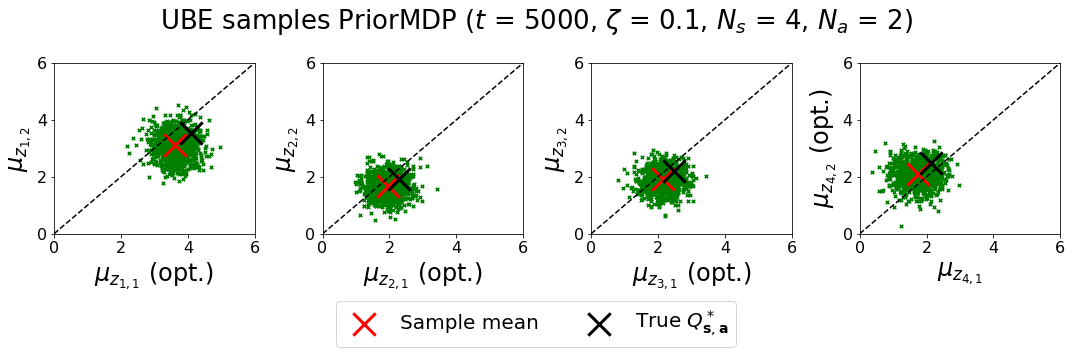

In [280]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, UbeNoUnrollAgent(agent_params), seed=0)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
Qmu = agent.Qmu_log[T]
Qvar = agent.Qvar_log[T]
for s in range(Ns):
    samples.append([])
    for i in range(1000):
        
        environment.s = s
        samples[-1].append(np.random.normal(Qmu[s, :], agent.zeta * Qvar[s, :]**0.5))
            
samples = np.array(samples).swapaxes(0, 1)

fig = plt.figure(figsize=(15, 5))
for s in range(Ns):
    
    plt.subplot(1, Ns, s + 1)
    
    plt.scatter(samples[:, s, 0], samples[:, s, 1], color='green', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, s, 0].mean(), 
                         samples[:, s, 1].mean(), 
                         color='red', 
                         marker='x', 
                         s=500,
                         linewidth=3)
    
    leg[1] = plt.scatter(Q[s, 0], Q[s, 1], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 6, 2), np.linspace(0, 6, 2), '--', color='black')
    
    plt.xlim([0, 6])
    plt.ylim([0, 6])
    
    xlabel = '$\mu_{z_{' + str(s + 1) + ', 1}}$'
    ylabel = '$\mu_{z_{' + str(s + 1) + ', 2}}$'
    
    if optimal_actions[s] == 0:
        xlabel += ' (opt.)'
    else:
        ylabel += ' (opt.)'
        
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    

plt.tight_layout()
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'UBE samples PriorMDP ($t$ = {}, $\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'
plt.suptitle(title.format(plot_time, agent.zeta, Ns, Na), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'ube-{}-{}-{}-{}-{}-scatter-priormdp-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na, plot_time)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()

# Moment Matching

In [281]:
# Agent constants
agent_params = {'gamma'            : 0.9,
                'kappa'            : 1.0,
                'mu0'              : 0.0,
                'lamda'            : 4.0,
                'alpha'            : 3.0,
                'beta'             : 3.0,
                'max_iter'         : max_iter,
                'zeta'             : 1.0,
                'num_dyn_samples'  : 100, 
                'sa_list'          : environment.sa_list()}

In [282]:
# for seed in tqdm(range(10)):

#     # Define agent
#     agent = MomentMatchingAgent(agent_params)

#     # Run experiment
#     run_experiment(environment=environment,
#                    agent=agent,
#                    seed=seed,
#                    num_time_steps=num_time_steps,
#                    max_buffer_length=max_buffer_length,
#                    save_every=save_every)

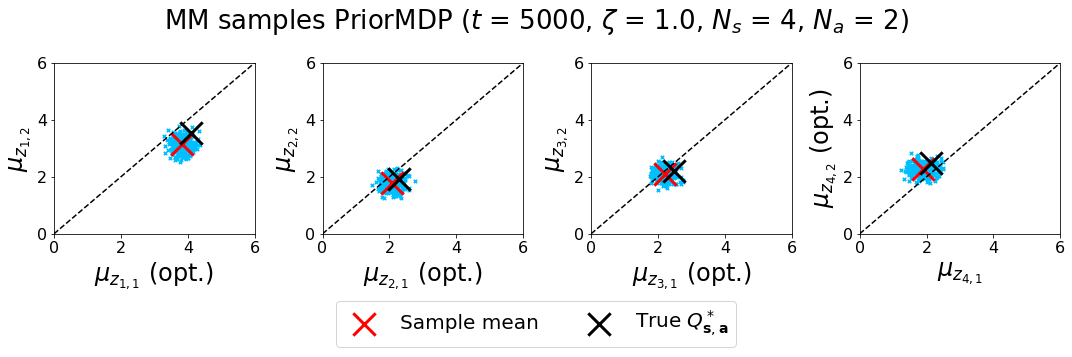

In [283]:
P, R = environment.get_mean_P_and_R()
pi, Q = solve_tabular_continuing_PI(P, R, gamma=0.9, max_iter=max_iter)

agent = load_agent(environment, MomentMatchingAgent(agent_params), seed=0)
samples = []

leg_names = ['Sample mean',
             'True $Q^*_{\\mathbf{s}, \\mathbf{a}}$']
leg = [None] * 2

T = plot_time // save_every
mu = agent.mu_log[T]
var = agent.var_log[T]
for s in range(Ns):
    samples.append([])
    for i in range(250):

        environment.s = s
        samples[-1].append(np.random.normal(mu[s, :], agent.zeta * var[s, :]**0.5))
            
samples = np.array(samples).swapaxes(0, 1)

fig = plt.figure(figsize=(15, 5))
for s in range(Ns):
    
    plt.subplot(1, Ns, s + 1)
    
    plt.scatter(samples[:, s, 0], samples[:, s, 1], color='deepskyblue', marker='x', s=12)
    
    leg[0] = plt.scatter(samples[:, s, 0].mean(), 
                         samples[:, s, 1].mean(), 
                         color='red', 
                         marker='x', 
                         s=500,
                         linewidth=3)
    
    leg[1] = plt.scatter(Q[s, 0], Q[s, 1], color='black', marker='x', s=500, linewidth=3)
    
    plt.plot(np.linspace(0, 6, 2), np.linspace(0, 6, 2), '--', color='black')
    
    plt.xlim([0, 6])
    plt.ylim([0, 6])
    
    xlabel = '$\mu_{z_{' + str(s + 1) + ', 1}}$'
    ylabel = '$\mu_{z_{' + str(s + 1) + ', 2}}$'
    
    if optimal_actions[s] == 0:
        xlabel += ' (opt.)'
    else:
        ylabel += ' (opt.)'
        
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    

plt.tight_layout()
plt.figlegend(leg, leg_names, loc = 'lower center', ncol=2, labelspacing=0., fontsize=20)
title = 'MM samples PriorMDP ($t$ = {}, $\zeta$ = {}, $N_s$ = {}, $N_a$ = {})'
plt.suptitle(title.format(plot_time, agent.zeta, Ns, Na), fontsize=26)
fig.subplots_adjust(top=0.825, bottom=0.35)

mu0, lamda, alpha, beta, zeta = agent.mu0, agent.lamda, agent.alpha, agent.beta, agent.zeta
save_name = 'mm-{}-{}-{}-{}-{}-scatter-priormdp-{}-{}-{}'.format(mu0, lamda, alpha, beta, zeta, Ns, Na, plot_time)
save_name = save_name.replace('.', '_')
plt.savefig(fig_loc + save_name + '.pdf', bbox_inches='tight')
plt.show()